Este cuadernillo contiene todo el código empleado para realizar la parte de nuestro TFM relativa al análisis del dataset Youtube Video Trending Dataset. Incluye las siguientes secciones:

- Instalación de subprogramas y librerías
- Preprocesamiento de los datos
- Obtención y análisis de características de los datos

## Instalación de subprogramas y librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import isodate #para manejar formato de duración ISO 8601
from textblob import TextBlob
from lingua import Language, LanguageDetectorBuilder

## Preprocesamiento de datos

In [2]:
# PASO 1: LECTURA DEL ARCHIVO
df = pd.read_csv("csv_final_merged.csv", low_memory=False)

In [3]:
# El primer paso del preprocesado es eliminar columnas que consideramos innecesarias para el estudio. Estas son: 
# channel_id,video_dimension, channel_have_hidden_subscribers, channel_localized_title, channel_localized_description
elim_columns = ['channel_id','video_dimension', 'channel_have_hidden_subscribers', 'channel_localized_title', 'channel_localized_description']
df = df.drop(columns=elim_columns)

In [4]:
#Debemos eliminar las filas con video_id nulo, ya que esa será la variable principal para la identificación de los vídeos.
#Según los metadatos ofrecidos por Kaggle, hay 13 instancias de ese tipo.
df = df.dropna(subset=['video_id'])

In [5]:
#A continuación trataremos el resto de valores NaN.
#Para columnas alfanuméricas (string), cambiar por ""
#Para columnas numéricas,
alfanumeric_values = {"video_trending_country": "", "video_description": "", "video_category_id": "", "video_tags": ""}

#de momento no

In [6]:
#Guardamos el dataset resultante en un csv para evitar repetir el proceso
df.to_csv('ytvg_clean.csv', index=False)

In [7]:
#Creamos un dataset auxiliar que contenga solamente una instancia de cada vídeo. Es decir, deberá tener unas 180.000 instancias.
df_unique = df.drop_duplicates(subset=['video_id'], keep='first')
df_unique.to_csv('ytvg_unique.csv', index=False)

## Obtención y análisis de características

In [8]:
df = pd.read_csv("ytvg_unique.csv", low_memory=False)

In [9]:
df.columns

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'video_title', 'video_description',
       'video_default_thumbnail', 'video_category_id', 'video_tags',
       'video_duration', 'video_definition', 'video_licensed_content',
       'video_view_count', 'video_like_count', 'video_comment_count',
       'channel_title', 'channel_description', 'channel_custom_url',
       'channel_published_at', 'channel_country', 'channel_view_count',
       'channel_subscriber_count', 'channel_video_count', 'thumbnail_url_hq',
       'thumbnail_faces_count', 'title_length', 'title_word_count',
       'title_has_exclamation', 'title_has_question', 'title_sentiment',
       'title_has_keywords', 'title_uppercase_ratio', 'description_length',
       'description_sentiment', 'has_external_links', 'tag_count',
       'video_duration_sec', 'published_at', 'hour_of_day', 'day_of_week',
       'is_weekend', 'is_peak_hour', 'video_category', 'views_per_sub',
      

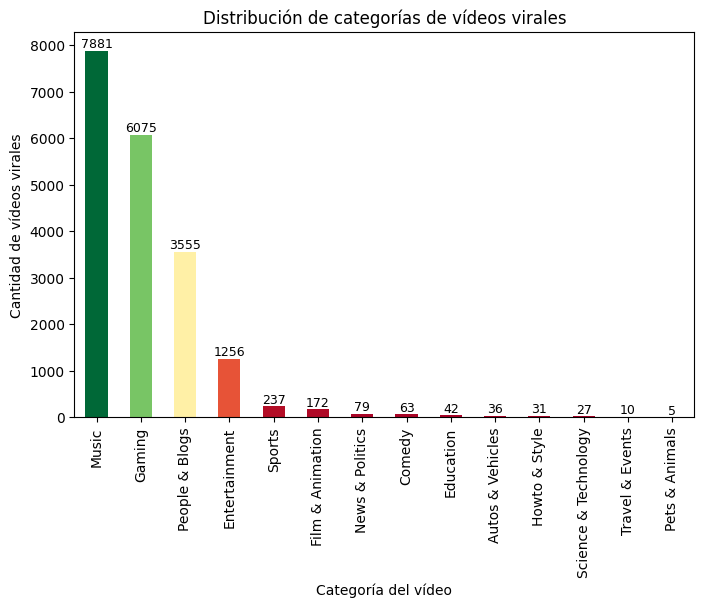

In [10]:
#Análisis de categorías
categories = df['video_category_id'].value_counts()
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de categorías de vídeos virales")
plt.xlabel("Categoría del vídeo")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [11]:
#Análisis de duración. Formato de la duración: ISO 8601
#Transformar todas las duraciones a segundos.
df["video_duration_segs"] = df["video_duration"].apply(lambda x: int(isodate.parse_duration(x).total_seconds()))
df["video_duration_segs"].describe()

count    19479.000000
mean      2890.563684
std       6268.480493
min          6.000000
25%        202.000000
50%        468.000000
75%       1812.000000
max      73561.000000
Name: video_duration_segs, dtype: float64

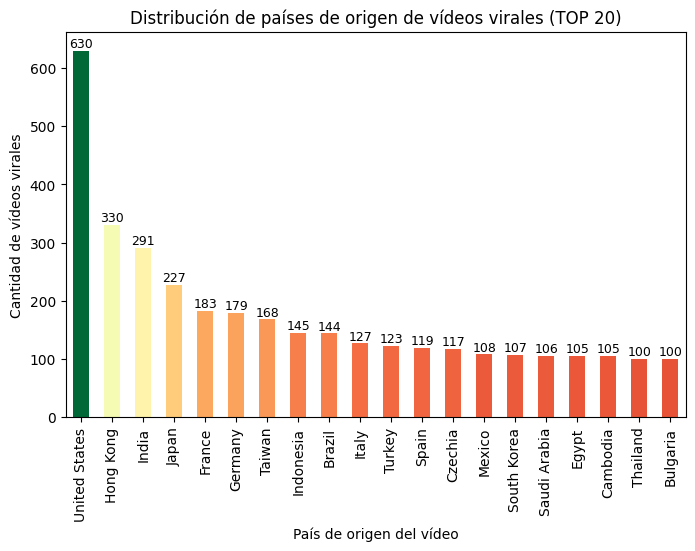

In [12]:
#País de origen de los vídeos
categories = df['channel_country'].value_counts()
categories = categories[0:20]
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de países de origen de vídeos virales (TOP 20)")
plt.xlabel("País de origen del vídeo")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [13]:
#Columnas para el idioma
languages = [Language.ENGLISH, Language.FRENCH, Language.GERMAN, Language.SPANISH, Language.ITALIAN, Language.PORTUGUESE, Language.ARABIC, Language.THAI, Language.HINDI, Language.CHINESE, Language.INDONESIAN, Language.RUSSIAN, Language.POLISH, Language.JAPANESE]
detector = LanguageDetectorBuilder.from_languages(*languages).with_preloaded_language_models().build()
#detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()
df['video_title_language'] = df['video_title'].apply(lambda x: str(detector.detect_language_of(str(x)))[9:])
df['vtl_confidence'] =  df['video_title'].apply(lambda x: detector.compute_language_confidence_values(str(x))[0].value)

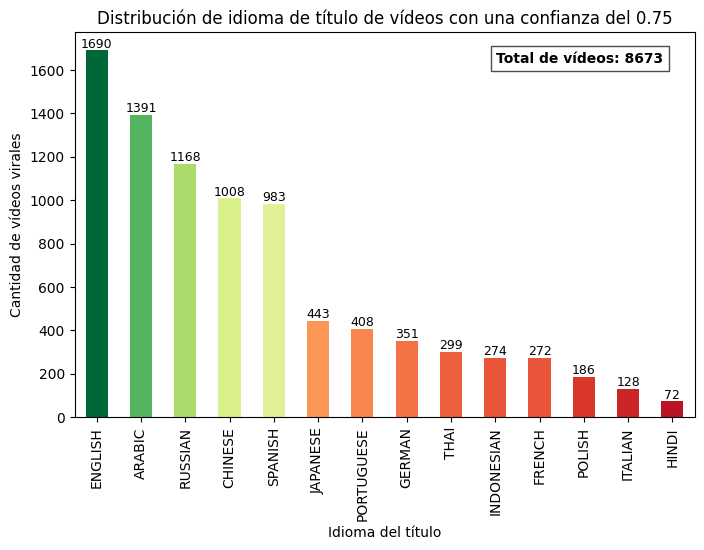

In [14]:
#Idioma de los títulos
confianza = 0.75
categories = df[df['vtl_confidence'] >= confianza]['video_title_language'].value_counts()
#categories = categories[0:20]
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de idioma de título de vídeos con una confianza del {confianza}")
plt.xlabel("Idioma del título")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

plt.text(0.95, 0.95, f"Total de vídeos: {categories.sum()}", 
         ha="right", va="top", transform=plt.gca().transAxes,
         fontsize=10, fontweight="bold", bbox=dict(facecolor="white", alpha=0.7))

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [15]:
df["video_title_len"] = df["video_title"].apply(lambda x: len(x))
df["title_word_count"]

0        16
1         7
2         5
3         3
4         6
         ..
19474     2
19475     9
19476     4
19477    11
19478     5
Name: title_word_count, Length: 19479, dtype: int64

In [16]:
len(df["video_title"][0])

68

In [17]:
#Análisis de título (idioma, tamaño, emojis)
df

,video_id,video_published_at,video_trending__date,video_trending_country,video_title,video_description,video_default_thumbnail,video_category_id,video_tags,video_duration,...,views_per_second,is_viral,viral_score,thumbnail_text_count,thumbnail_colorfulness,views_per_subscriber,video_duration_segs,video_title_language,vtl_confidence,video_title_len
0,2ttVjSrLEZE,2024-10-02T15:00:27Z,2024.10.12,United Arab Emirates,Ayed - Ma Hada Bali | Official Music Video 202...,للإشتراك في القناة | https://rb.gy/7wjde8\nللا...,https://i.ytimg.com/vi/2ttVjSrLEZE/default.jpg,Music,"Ayed,Ayedh Yousef,Ma Hada Bali,أجدد الأغاني ال...",PT5M1S,...,5407.291391,1,1137.770604,0.0,11.933030,112.613061,301,ENGLISH,0.408419,68
1,cyCfVb0_FZg,2024-09-26T16:00:22Z,2024.10.12,Bulgaria,SHUNAKA - Mr.DaiMiPariteSi [OFFICIAL 4K VIDEO]...,Subscribe to Shunaka: https://bit.ly/3Mt8U6h\n...,https://i.ytimg.com/vi/cyCfVb0_FZg/default.jpg,Music,"shunaka,dsd,dim4ou,vrgo,virgo,trf,boro,purvi,p...",PT2M40S,...,669.881988,1,138.800536,0.0,66.092611,9.628694,160,ENGLISH,0.486808,51
2,O2XDDmyuycw,2024-09-27T07:00:06Z,2024.10.12,Bulgaria,Robi - Тихо (Official Video),"""Тихо, тихо, тихо... оставам с тебе""\n\nПърва ...",https://i.ytimg.com/vi/O2XDDmyuycw/default.jpg,Music,"роби,robi,tiho,tiho tiho,molec,молец,тихо,тихо...",PT2M53S,...,787.114943,1,161.039149,0.0,22.409323,7.207936,173,ENGLISH,0.320152,28
3,IoHXh4oGZM8,2024-09-22T08:08:44Z,2024.10.12,Bosnia and Herzegovina,"September 22, 2024",NaN,https://i.ytimg.com/vi/IoHXh4oGZM8/default.jpg,Entertainment,NaN,PT39S,...,6058.800000,1,1220.609273,0.0,25.591613,17.688636,39,INDONESIAN,0.471172,18
4,nPBCrqxz30w,2024-09-17T16:00:45Z,2024.10.12,Bosnia and Herzegovina,Ja sa 32 i 102 godine😂,Dobro došli u život jedne prosečne balkanske p...,https://i.ytimg.com/vi/nPBCrqxz30w/default.jpg,People & Blogs,NaN,PT13S,...,15765.357143,1,3159.208888,0.0,18.225224,12.261263,13,FRENCH,0.182891,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19474,cKuvkKw8VKY,2025-09-01T23:00:42Z,NaN,NaN,០១ វគ្គមេចម្លែកៗៗមានហេរូ....,ចុចដើម្បីបានQR🤞: https://pay.ababank.com/uBLeP...,https://i.ytimg.com/vi/cKuvkKw8VKY/default.jpg,People & Blogs,"iqgaming,iqgaming survival,modpacks,oneblock,l...",PT21M56S,...,3.445710,0,1.295164,0.0,49.464133,NaN,1316,,0.000000,28
19475,VmMsRy56jHw,2025-09-02T14:25:56Z,NaN,NaN,🔴LIVE |​ Tyyy - RANK GAME 5MAN FLASH KH,Rank Game Full Squad Flash KH\n———————\nABA: 0...,https://i.ytimg.com/vi/VmMsRy56jHw/default_liv...,Gaming,NaN,PT1H54M2S,...,0.369136,0,0.658431,0.0,89.532943,NaN,6842,ENGLISH,0.469766,39
19476,_aH4svsCRh0,2025-09-02T04:30:33Z,NaN,NaN,សុំមកបែបដៃគូអភិជនម្ដងមើល៎😌🤌 || mobile legends,NaN,https://i.ytimg.com/vi/_aH4svsCRh0/default.jpg,Gaming,NaN,PT3M30S,...,14.241706,0,0.342809,0.0,58.096414,NaN,210,GERMAN,0.404368,45
19477,G3M3T3fEPZI,2025-09-01T15:47:22Z,NaN,NaN,🔴LIVE|YOO YOO Welcome Back With Seth Guy! Game...,----------------------------------------------...,https://i.ytimg.com/vi/G3M3T3fEPZI/default_liv...,Gaming,"Valorant,Khmer,VTB Clan,Anh Seth,LyTaMo,Game,K...",PT1H47M6S,...,0.213941,0,0.303736,0.0,42.177544,NaN,6426,ENGLISH,0.872888,79


## Preprocesamiento títulos - análisis de sentimientos

In [18]:
#funcion para extraer algunas características del título
def extract_features(df):
    df['title_length'] = df['video_title'].apply(lambda x: len(str(x)))
    df['title_word_count'] = df['video_title'].apply(lambda x: len(str(x).split()))
    df['title_has_exclamation'] = df['video_title'].apply(lambda x: '!' in str(x))
    df['title_has_question'] = df['video_title'].apply(lambda x: '?' in str(x))
    df['title_sentiment'] = df['video_title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['description_length'] = df['video_description'].apply(lambda x: len(str(x)))
    df['description_sentiment'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df

In [19]:
df_preproc = df
df_preproc = extract_features(df_preproc)

# 2. Eliminar columnas irrelevantes y peligrosas para evitar fuga de datos
# Explicación:
# Eliminamos identificadores, URLs, descripciones redundantes, el target y cualquier variable derivada del target.
# Así evitamos fuga de datos y aseguramos que el modelo solo use información disponible antes de saber si un vídeo es viral.
# No eliminamos variables originales del vídeo/canal ni features extraídas del texto.

# Preprocesado para predicción antes de publicar
# Elimina TODAS las variables de interacción y métricas post-publicación
cols_to_drop = [
    'video_id', 'channel_id', 'video_default_thumbnail', 'thumbnail_url_hq',
    'channel_title', 'channel_description', 'channel_custom_url',
    'channel_localized_title', 'channel_localized_description', 'published_at',
    'is_viral', 'viral_score',  # targets
    'video_view_count', 'video_like_count', 'video_comment_count',
    'views_per_second', 'likes_per_view', 'likes_per_sub', 'views_per_sub','views_per_subscriber',
    'channel_view_count', 'channel_subscriber_count', 'channel_video_count'
]
cols_to_drop += ['video_tags', 'channel_country']
df_preproc_clf = df.copy()
df_preproc_clf = extract_features(df_preproc_clf)
df_preproc_clf.drop(columns=[col for col in cols_to_drop if col in df_preproc_clf.columns], inplace=True)

# Eliminar columnas con todos los valores NaN antes de imputar
cols_all_nan = [col for col in df_preproc_clf.columns if df_preproc_clf[col].isna().all()]
df_preproc_clf.drop(columns=cols_all_nan, inplace=True)

# Imputar nulos y codificar categóricas
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_preproc_clf.select_dtypes(include='object').columns
for col in cat_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna('Unknown').astype(str)
    from sklearn.preprocessing import LabelEncoder
    df_preproc_clf[col] = LabelEncoder().fit_transform(df_preproc_clf[col])
for col in num_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna(df_preproc_clf[col].median())

# Eliminar columnas constantes antes de escalar
from pandas.api.types import is_numeric_dtype
cols_constant = [col for col in df_preproc_clf.columns if is_numeric_dtype(df_preproc_clf[col]) and df_preproc_clf[col].nunique() <= 1]
df_preproc_clf.drop(columns=cols_constant, inplace=True)

# Estandarizar numéricas
from sklearn.preprocessing import StandardScaler
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df_preproc_clf[num_cols] = scaler.fit_transform(df_preproc_clf[num_cols])

In [20]:
df_preproc = df
df_preproc = extract_features(df_preproc)

# 2. Eliminar columnas irrelevantes y peligrosas para evitar fuga de datos
# Explicación:
# Eliminamos identificadores, URLs, descripciones redundantes, el target y cualquier variable derivada del target.
# Así evitamos fuga de datos y aseguramos que el modelo solo use información disponible antes de saber si un vídeo es viral.
# No eliminamos variables originales del vídeo/canal ni features extraídas del texto.

# Preprocesado para predicción antes de publicar
# Elimina TODAS las variables de interacción y métricas post-publicación
cols_to_drop = [
    'video_id', 'channel_id', 'video_default_thumbnail', 'thumbnail_url_hq',
    'channel_title', 'channel_description', 'channel_custom_url',
    'channel_localized_title', 'channel_localized_description', 'published_at',
    'is_viral', 'viral_score',  # targets
    'video_view_count', 'video_like_count', 'video_comment_count',
    'views_per_second', 'likes_per_view', 'likes_per_sub', 'views_per_sub','views_per_subscriber',
    'channel_view_count', 'channel_subscriber_count', 'channel_video_count'
]
cols_to_drop += ['video_tags', 'channel_country']
df_preproc_clf = df.copy()
df_preproc_clf = extract_features(df_preproc_clf)
df_preproc_clf.drop(columns=[col for col in cols_to_drop if col in df_preproc_clf.columns], inplace=True)

# Eliminar columnas con todos los valores NaN antes de imputar
cols_all_nan = [col for col in df_preproc_clf.columns if df_preproc_clf[col].isna().all()]
df_preproc_clf.drop(columns=cols_all_nan, inplace=True)

# Imputar nulos y codificar categóricas
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_preproc_clf.select_dtypes(include='object').columns
for col in cat_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna('Unknown').astype(str)
    from sklearn.preprocessing import LabelEncoder
    df_preproc_clf[col] = LabelEncoder().fit_transform(df_preproc_clf[col])
for col in num_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna(df_preproc_clf[col].median())

# Eliminar columnas constantes antes de escalar
from pandas.api.types import is_numeric_dtype
cols_constant = [col for col in df_preproc_clf.columns if is_numeric_dtype(df_preproc_clf[col]) and df_preproc_clf[col].nunique() <= 1]
df_preproc_clf.drop(columns=cols_constant, inplace=True)

# Estandarizar numéricas
from sklearn.preprocessing import StandardScaler
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df_preproc_clf[num_cols] = scaler.fit_transform(df_preproc_clf[num_cols])

In [21]:
df_preproc

,video_id,video_published_at,video_trending__date,video_trending_country,video_title,video_description,video_default_thumbnail,video_category_id,video_tags,video_duration,...,views_per_second,is_viral,viral_score,thumbnail_text_count,thumbnail_colorfulness,views_per_subscriber,video_duration_segs,video_title_language,vtl_confidence,video_title_len
0,2ttVjSrLEZE,2024-10-02T15:00:27Z,2024.10.12,United Arab Emirates,Ayed - Ma Hada Bali | Official Music Video 202...,للإشتراك في القناة | https://rb.gy/7wjde8\nللا...,https://i.ytimg.com/vi/2ttVjSrLEZE/default.jpg,Music,"Ayed,Ayedh Yousef,Ma Hada Bali,أجدد الأغاني ال...",PT5M1S,...,5407.291391,1,1137.770604,0.0,11.933030,112.613061,301,ENGLISH,0.408419,68
1,cyCfVb0_FZg,2024-09-26T16:00:22Z,2024.10.12,Bulgaria,SHUNAKA - Mr.DaiMiPariteSi [OFFICIAL 4K VIDEO]...,Subscribe to Shunaka: https://bit.ly/3Mt8U6h\n...,https://i.ytimg.com/vi/cyCfVb0_FZg/default.jpg,Music,"shunaka,dsd,dim4ou,vrgo,virgo,trf,boro,purvi,p...",PT2M40S,...,669.881988,1,138.800536,0.0,66.092611,9.628694,160,ENGLISH,0.486808,51
2,O2XDDmyuycw,2024-09-27T07:00:06Z,2024.10.12,Bulgaria,Robi - Тихо (Official Video),"""Тихо, тихо, тихо... оставам с тебе""\n\nПърва ...",https://i.ytimg.com/vi/O2XDDmyuycw/default.jpg,Music,"роби,robi,tiho,tiho tiho,molec,молец,тихо,тихо...",PT2M53S,...,787.114943,1,161.039149,0.0,22.409323,7.207936,173,ENGLISH,0.320152,28
3,IoHXh4oGZM8,2024-09-22T08:08:44Z,2024.10.12,Bosnia and Herzegovina,"September 22, 2024",NaN,https://i.ytimg.com/vi/IoHXh4oGZM8/default.jpg,Entertainment,NaN,PT39S,...,6058.800000,1,1220.609273,0.0,25.591613,17.688636,39,INDONESIAN,0.471172,18
4,nPBCrqxz30w,2024-09-17T16:00:45Z,2024.10.12,Bosnia and Herzegovina,Ja sa 32 i 102 godine😂,Dobro došli u život jedne prosečne balkanske p...,https://i.ytimg.com/vi/nPBCrqxz30w/default.jpg,People & Blogs,NaN,PT13S,...,15765.357143,1,3159.208888,0.0,18.225224,12.261263,13,FRENCH,0.182891,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19474,cKuvkKw8VKY,2025-09-01T23:00:42Z,NaN,NaN,០១ វគ្គមេចម្លែកៗៗមានហេរូ....,ចុចដើម្បីបានQR🤞: https://pay.ababank.com/uBLeP...,https://i.ytimg.com/vi/cKuvkKw8VKY/default.jpg,People & Blogs,"iqgaming,iqgaming survival,modpacks,oneblock,l...",PT21M56S,...,3.445710,0,1.295164,0.0,49.464133,NaN,1316,,0.000000,28
19475,VmMsRy56jHw,2025-09-02T14:25:56Z,NaN,NaN,🔴LIVE |​ Tyyy - RANK GAME 5MAN FLASH KH,Rank Game Full Squad Flash KH\n———————\nABA: 0...,https://i.ytimg.com/vi/VmMsRy56jHw/default_liv...,Gaming,NaN,PT1H54M2S,...,0.369136,0,0.658431,0.0,89.532943,NaN,6842,ENGLISH,0.469766,39
19476,_aH4svsCRh0,2025-09-02T04:30:33Z,NaN,NaN,សុំមកបែបដៃគូអភិជនម្ដងមើល៎😌🤌 || mobile legends,NaN,https://i.ytimg.com/vi/_aH4svsCRh0/default.jpg,Gaming,NaN,PT3M30S,...,14.241706,0,0.342809,0.0,58.096414,NaN,210,GERMAN,0.404368,45
19477,G3M3T3fEPZI,2025-09-01T15:47:22Z,NaN,NaN,🔴LIVE|YOO YOO Welcome Back With Seth Guy! Game...,----------------------------------------------...,https://i.ytimg.com/vi/G3M3T3fEPZI/default_liv...,Gaming,"Valorant,Khmer,VTB Clan,Anh Seth,LyTaMo,Game,K...",PT1H47M6S,...,0.213941,0,0.303736,0.0,42.177544,NaN,6426,ENGLISH,0.872888,79


## Predicción de viralidad antes de publicar el vídeo

En este enfoque, el modelo solo utilizará información disponible antes de la publicación (título, descripción, categoría, duración, horario, etc.) para predecir si un vídeo será viral. Se eliminan todas las variables de interacción y métricas que solo se conocen tras la publicación.

In [22]:
if 'is_viral' in df:
    # Elimina filas con NaN en el target y sincroniza features
    mask = ~df['is_viral'].isna()
    df = df[mask].reset_index(drop=True)
    df_preproc_clf = df_preproc_clf[mask].reset_index(drop=True)
    y_clf = df['is_viral']
    X_clf = df_preproc_clf.copy()
    # Comprobación final
    assert not y_clf.isna().any(), "Error: El target contiene NaN tras la limpieza."
    assert X_clf.shape[0] == y_clf.shape[0], "Error: Desajuste entre X e y tras la limpieza."
else:
    raise ValueError("La columna 'is_viral' no existe en el DataFrame.")

In [23]:
# Definir X e y para clasificación binaria (viral/no viral)
from sklearn.model_selection import train_test_split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print('Shape X_train:', X_train_clf.shape)
print('Shape y_train:', y_train_clf.shape)
print('Proporción de clases en train:', y_train_clf.value_counts(normalize=True))


Shape X_train: (15583, 33)
Shape y_train: (15583,)
Proporción de clases en train: is_viral
1    0.682025
0    0.317975
Name: proportion, dtype: float64


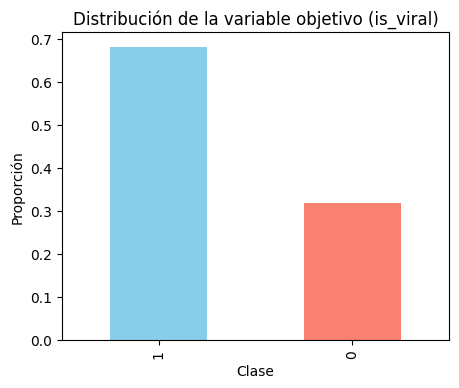

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
y_clf.value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de la variable objetivo (is_viral)')
plt.xlabel('Clase')
plt.ylabel('Proporción')
plt.show()

In [25]:
# Entrenamiento y evaluación de modelos de clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier

models_clf = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
    'RandomForest': RandomForestClassifier(
        n_estimators=50,           # menos árboles
        max_depth=5,               # profundidad máxima limitada
        min_samples_split=10,      # mínimo de muestras para dividir
        min_samples_leaf=5,        # mínimo de muestras por hoja
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=3000)
}

results_clf = {}
for name, model in models_clf.items():
    model.fit(X_train_clf, y_train_clf)
    y_pred = model.predict(X_test_clf)
    
    acc = accuracy_score(y_test_clf, y_pred)
    prec = precision_score(y_test_clf, y_pred)
    rec = recall_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred)
    
    results_clf[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1
    }
    
    print(f"\n{name}")
    print(classification_report(y_test_clf, y_pred, digits=3))

# Resumen de resultados
results_clf_df = pd.DataFrame(results_clf).T
print("\nResumen de resultados:")
print(results_clf_df.sort_values('F1-score', ascending=False))


LogisticRegression
              precision    recall  f1-score   support

           0      0.666     0.477     0.556      1239
           1      0.785     0.889     0.833      2657

    accuracy                          0.758      3896
   macro avg      0.725     0.683     0.695      3896
weighted avg      0.747     0.758     0.745      3896


RandomForest
              precision    recall  f1-score   support

           0      0.700     0.430     0.533      1239
           1      0.775     0.914     0.839      2657

    accuracy                          0.760      3896
   macro avg      0.738     0.672     0.686      3896
weighted avg      0.751     0.760     0.742      3896



c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:16:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost
              precision    recall  f1-score   support

           0      0.779     0.710     0.743      1239
           1      0.870     0.906     0.888      2657

    accuracy                          0.844      3896
   macro avg      0.825     0.808     0.816      3896
weighted avg      0.841     0.844     0.842      3896


MLPClassifier
              precision    recall  f1-score   support

           0      0.643     0.620     0.631      1239
           1      0.826     0.839     0.832      2657

    accuracy                          0.770      3896
   macro avg      0.734     0.730     0.732      3896
weighted avg      0.767     0.770     0.768      3896


Resumen de resultados:
                    Accuracy  Precision    Recall  F1-score
XGBoost             0.843943   0.870257  0.906285  0.887906
RandomForest        0.760267   0.774801  0.914189  0.838743
LogisticRegression  0.757700   0.784646  0.888596  0.833392
MLPClassifier       0.769507   0.825620  0.839292  0.83240

### Validación cruzada, matriz de confusión y curvas de aprendizaje
A continuación se implementan mejoras para validar la robustez del modelo:
- Validación cruzada estratificada (StratifiedKFold) para obtener métricas más robustas.
- Visualización de la matriz de confusión para analizar errores.
- Curvas de aprendizaje para detectar overfitting/underfitting.

In [26]:
from sklearn.model_selection import StratifiedKFold, cross_validate

# Validación cruzada estratificada 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']

for name, model in models_clf.items():
    print(f"\n{name} - Validación cruzada (5 folds):")
    scores = cross_validate(model, X_clf, y_clf, cv=cv, scoring=scoring, n_jobs=-1)
    
    print(f"Accuracy:  {scores['test_accuracy'].mean():.3f} ± {scores['test_accuracy'].std():.3f}")
    print(f"Precision: {scores['test_precision'].mean():.3f} ± {scores['test_precision'].std():.3f}")
    print(f"Recall:    {scores['test_recall'].mean():.3f} ± {scores['test_recall'].std():.3f}")
    print(f"F1-score:  {scores['test_f1'].mean():.3f} ± {scores['test_f1'].std():.3f}")


LogisticRegression - Validación cruzada (5 folds):
Accuracy:  0.751 ± 0.006
Precision: 0.781 ± 0.003
Recall:    0.881 ± 0.007
F1-score:  0.828 ± 0.004

RandomForest - Validación cruzada (5 folds):
Accuracy:  0.762 ± 0.003
Precision: 0.779 ± 0.004
Recall:    0.909 ± 0.004
F1-score:  0.839 ± 0.002

XGBoost - Validación cruzada (5 folds):
Accuracy:  0.835 ± 0.005
Precision: 0.864 ± 0.004
Recall:    0.900 ± 0.007
F1-score:  0.881 ± 0.004

MLPClassifier - Validación cruzada (5 folds):
Accuracy:  0.779 ± 0.006
Precision: 0.827 ± 0.008
Recall:    0.854 ± 0.007
F1-score:  0.840 ± 0.004


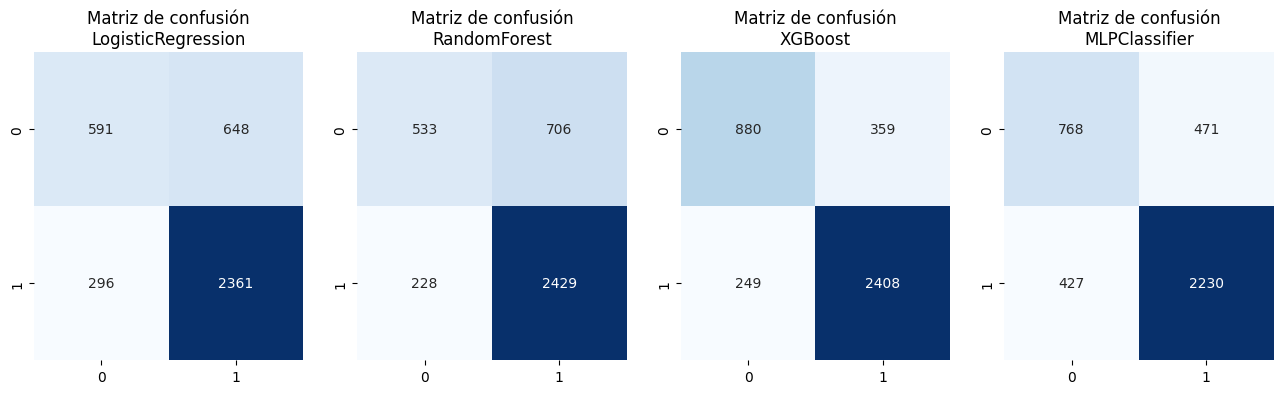

In [40]:
# Heatmap de la matriz de confusión para todos los modelos

from sklearn.metrics import confusion_matrix
import seaborn as sns

model_names = ['LogisticRegression', 'RandomForest', 'XGBoost', 'MLPClassifier']
plt.figure(figsize=(16,4))

for i, name in enumerate(model_names):
    model = models_clf[name]
    y_pred = model.predict(X_test_clf)
    cm = confusion_matrix(y_test_clf, y_pred)
    plt.subplot(1, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de confusión\n{name}')


Matriz de confusión para LogisticRegression:
[[ 591  648]
 [ 296 2361]]


Matriz de confusión para RandomForest:
[[ 533  706]
 [ 228 2429]]


Matriz de confusión para XGBoost:
[[ 880  359]
 [ 249 2408]]


Matriz de confusión para MLPClassifier:
[[ 768  471]
 [ 427 2230]]



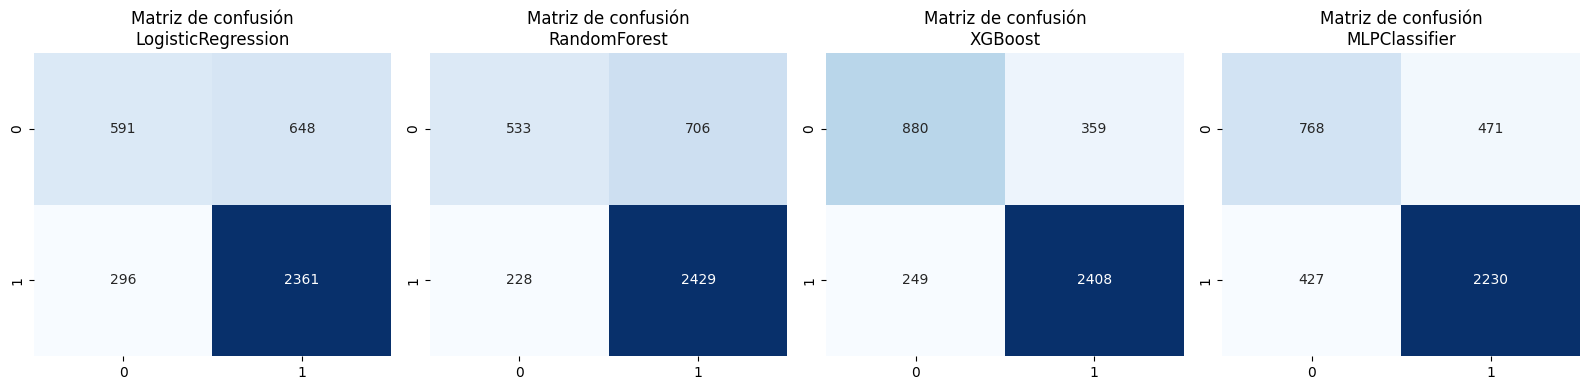

In [53]:
# Heatmap de la matriz de confusión para todos los modelos
from sklearn.metrics import confusion_matrix
import seaborn as sns

model_names = ['LogisticRegression', 'RandomForest', 'XGBoost', 'MLPClassifier']
plt.figure(figsize=(16,4))

for i, name in enumerate(model_names):
    model = models_clf[name]
    y_pred = model.predict(X_test_clf)
    cm = confusion_matrix(y_test_clf, y_pred)
    print(f"\nMatriz de confusión para {name}:\n{cm}\n")  # Mostrar en consola
    plt.subplot(1, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de confusión\n{name}')
plt.tight_layout()
plt.show()

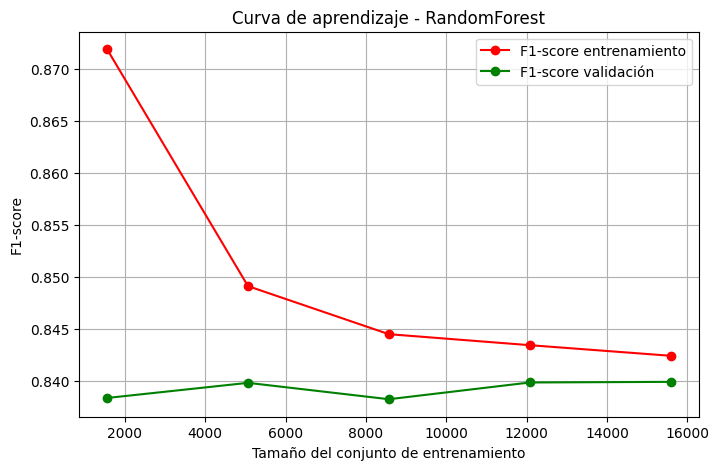

In [28]:
from sklearn.model_selection import learning_curve, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    models_clf['RandomForest'], X_clf, y_clf, cv=cv, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='F1-score entrenamiento')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='F1-score validación')
plt.title('Curva de aprendizaje - RandomForest')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('F1-score')
plt.legend(loc='best')
plt.grid()
plt.show()

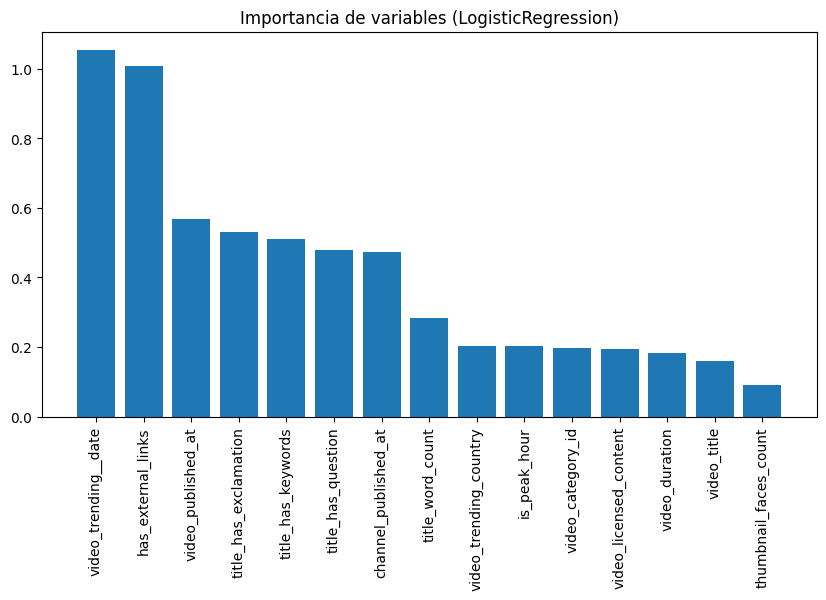

,feature,importance
1,video_trending__date,1.054158
20,has_external_links,1.008098
0,video_published_at,0.568371
13,title_has_exclamation,0.531556
16,title_has_keywords,0.509927
14,title_has_question,0.478902
9,channel_published_at,0.473171
12,title_word_count,0.283568
2,video_trending_country,0.203535
26,is_peak_hour,0.202367


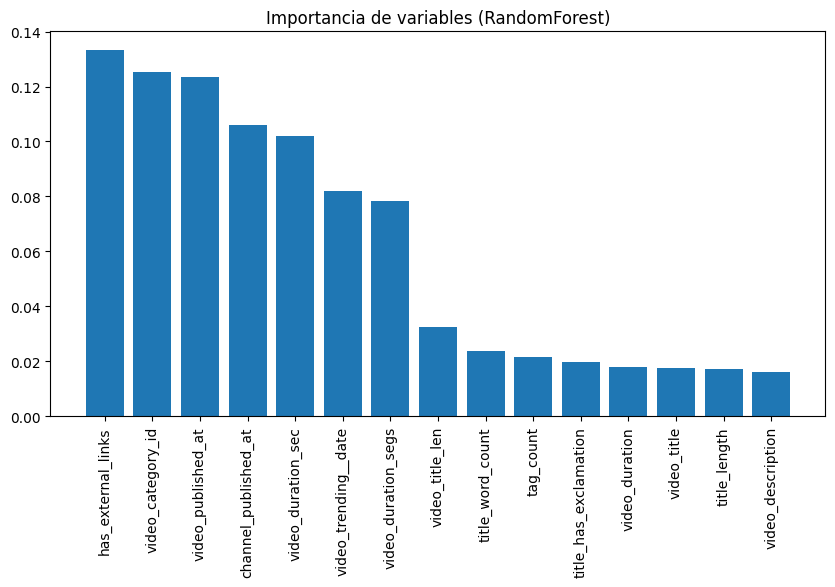

,feature,importance
20,has_external_links,0.133373
5,video_category_id,0.125328
0,video_published_at,0.123553
9,channel_published_at,0.106081
22,video_duration_sec,0.102034
1,video_trending__date,0.081902
29,video_duration_segs,0.078376
32,video_title_len,0.032486
12,title_word_count,0.023837
21,tag_count,0.021554


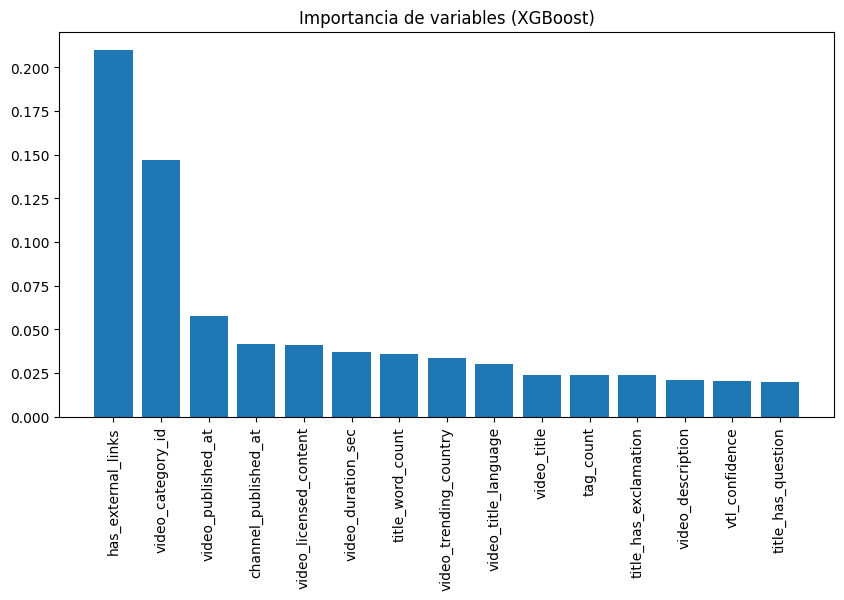

,feature,importance
20,has_external_links,0.209951
5,video_category_id,0.146709
0,video_published_at,0.057310
9,channel_published_at,0.041535
8,video_licensed_content,0.040781
22,video_duration_sec,0.036700
12,title_word_count,0.035961
2,video_trending_country,0.033638
30,video_title_language,0.029795
3,video_title,0.024049


In [42]:
# Importancia de variables para todos los modelos compatibles

import matplotlib.pyplot as plt
import pandas as pd

for name, model in models_clf.items():
    # RandomForest y XGBoost usan feature_importances_
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        features = X_train_clf.columns
        imp_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
        plt.figure(figsize=(10,5))
        plt.bar(imp_df['feature'][:15], imp_df['importance'][:15])
        plt.xticks(rotation=90)
        plt.title(f'Importancia de variables ({name})')
        plt.show()
        display(imp_df.head(15))
    # LogisticRegression usa coef_
    elif hasattr(model, "coef_"):
        importances = abs(model.coef_[0])
        features = X_train_clf.columns
        imp_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
        plt.figure(figsize=(10,5))
        plt.bar(imp_df['feature'][:15], imp_df['importance'][:15])
        plt.xticks(rotation=90)
        plt.title(f'Importancia de variables ({name})')
        plt.show()
        display(imp_df.head(15))
    # Otros modelos pueden requerir métodos específicos

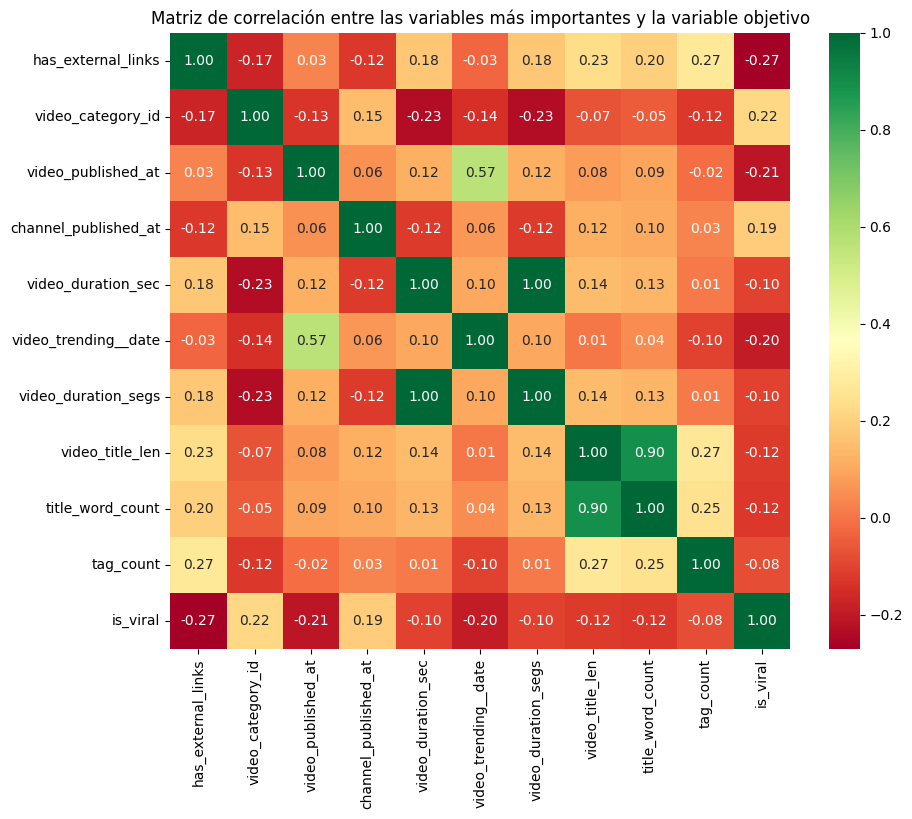

In [41]:
# Gráfico de correlación entre las variables más importantes y la variable objetivo

import seaborn as sns

# Seleccionamos las 10 variables más importantes de RandomForest
importances = models_clf['RandomForest'].feature_importances_
features = X_train_clf.columns
imp_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
top_features = imp_df['feature'][:10].tolist()

# Creamos un DataFrame temporal con las variables más importantes
corr_df = X_clf[top_features].copy()
# Añadimos la variable objetivo desde el DataFrame original
corr_df['is_viral'] = y_clf.values

# Calculamos la matriz de correlación
corr_matrix = corr_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Matriz de correlación entre las variables más importantes y la variable objetivo')
plt.show()

### Optimización y ajuste de modelos
En esta sección se implementan:
- Búsqueda de hiperparámetros con GridSearchCV/RandomizedSearchCV.
- Técnicas de balanceo de clases (SMOTE y class_weight).
- Ajuste del umbral de decisión para maximizar la métrica F1.

In [30]:
# Balanceo de clases con SMOTE y ajuste de class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_clf, y_train_clf)
print('Distribución de clases tras SMOTE:', Counter(y_train_bal))

# Actualizar modelos con class_weight='balanced' donde aplica
models_bal = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train_bal)-sum(y_train_bal))/sum(y_train_bal)),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=3000)
}


Distribución de clases tras SMOTE: Counter({0: 10628, 1: 10628})


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Hiperparámetros para RandomForest
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist_rf, n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42
)
rf_search.fit(X_train_bal, y_train_bal)
print('Mejores hiperparámetros RandomForest:', rf_search.best_params_)

# Hiperparámetros para XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
xgb_search = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss',
                  scale_pos_weight=(len(y_train_bal)-sum(y_train_bal))/sum(y_train_bal)),
    param_distributions=param_dist_xgb, n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42
)
xgb_search.fit(X_train_bal, y_train_bal)
print('Mejores hiperparámetros XGBoost:', xgb_search.best_params_)

# Hiperparámetros para LogisticRegression
param_dist_lr = {
    'C': np.logspace(-2, 2, 10),
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2']
}
lr_search = RandomizedSearchCV(
    LogisticRegression(max_iter=500, random_state=42, class_weight='balanced'),
    param_distributions=param_dist_lr, n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42
)
lr_search.fit(X_train_bal, y_train_bal)
print('Mejores hiperparámetros LogisticRegression:', lr_search.best_params_)

# Hiperparámetros para MLPClassifier
param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100,50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01]
}
mlp_search = RandomizedSearchCV(
    MLPClassifier(random_state=42, max_iter=3000),
    param_distributions=param_dist_mlp, n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42
)
mlp_search.fit(X_train_bal, y_train_bal)
print('Mejores hiperparámetros MLPClassifier:', mlp_search.best_params_)

Mejores hiperparámetros RandomForest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:32:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores hiperparámetros XGBoost: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2}
Mejores hiperparámetros LogisticRegression: {'solver': 'liblinear', 'penalty': 'l2', 'C': np.float64(35.93813663804626)}
Mejores hiperparámetros MLPClassifier: {'solver': 'adam', 'hidden_layer_sizes': (100, 50), 'alpha': 0.01, 'activation': 'relu'}


In [49]:
from sklearn.metrics import f1_score, precision_recall_curve, classification_report

# Ajuste de umbral óptimo para maximizar F1-score en todos los modelos
model_names = ['RandomForest', 'XGBoost', 'LogisticRegression', 'MLPClassifier']
model_objs = [
    rf_search.best_estimator_,
    xgb_search.best_estimator_,
    lr_search.best_estimator_,
    mlp_search.best_estimator_
]

thresholds_dict = {}
f1_dict = {}

for name, model in zip(model_names, model_objs):
    model.fit(X_train_bal, y_train_bal)
    y_proba = model.predict_proba(X_test_clf)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_test_clf, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    thresholds_dict[name] = best_threshold
    f1_dict[name] = f1_scores[best_idx]
    print(f"\n{name} - Mejor umbral para F1: {best_threshold:.2f} (F1={f1_scores[best_idx]:.3f})")
    y_pred_opt = (y_proba >= best_threshold).astype(int)
    print(f"Reporte clasificación con umbral óptimo:\n", classification_report(y_test_clf, y_pred_opt))


RandomForest - Mejor umbral para F1: 0.43 (F1=0.890)
Reporte clasificación con umbral óptimo:
               precision    recall  f1-score   support

           0       0.82      0.65      0.73      1239
           1       0.85      0.93      0.89      2657

    accuracy                           0.84      3896
   macro avg       0.84      0.79      0.81      3896
weighted avg       0.84      0.84      0.84      3896



c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:37:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost - Mejor umbral para F1: 0.29 (F1=0.890)
Reporte clasificación con umbral óptimo:
               precision    recall  f1-score   support

           0       0.82      0.64      0.72      1239
           1       0.85      0.94      0.89      2657

    accuracy                           0.84      3896
   macro avg       0.84      0.79      0.81      3896
weighted avg       0.84      0.84      0.84      3896


LogisticRegression - Mejor umbral para F1: 0.22 (F1=0.834)
Reporte clasificación con umbral óptimo:
               precision    recall  f1-score   support

           0       0.72      0.33      0.45      1239
           1       0.75      0.94      0.83      2657

    accuracy                           0.74      3896
   macro avg       0.73      0.63      0.64      3896
weighted avg       0.74      0.74      0.71      3896


MLPClassifier - Mejor umbral para F1: 0.01 (F1=0.848)
Reporte clasificación con umbral óptimo:
               precision    recall  f1-score   support

 

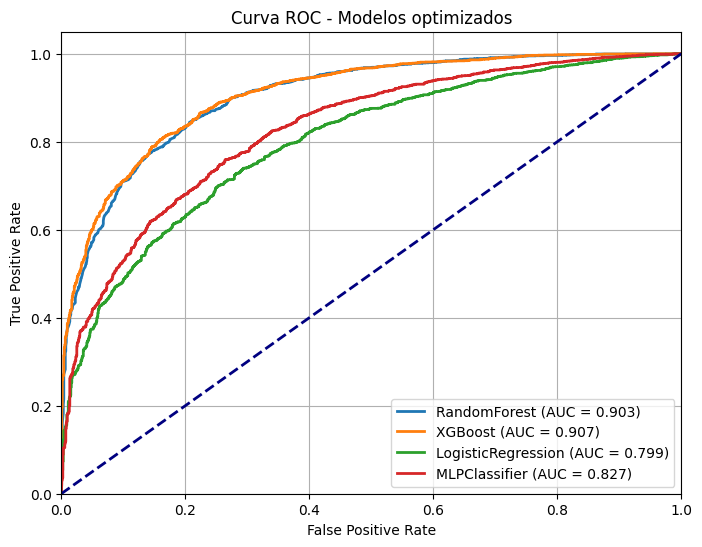

In [52]:
# Curva ROC para los modelos optimizados
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for name, model in zip(['RandomForest', 'XGBoost', 'LogisticRegression', 'MLPClassifier'],
                       [rf_search.best_estimator_, xgb_search.best_estimator_, lr_search.best_estimator_, mlp_search.best_estimator_]):
    y_proba = model.predict_proba(X_test_clf)[:,1]
    fpr, tpr, _ = roc_curve(y_test_clf, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelos optimizados')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Resumen de resultados y comparación de modelos

A continuación se presenta una tabla comparativa con las principales métricas obtenidas por cada modelo tras el proceso de optimización y ajuste:

```

In [50]:
# Tabla comparativa de métricas finales
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Resultados tras ajuste de umbral óptimo para cada modelo
final_results = {}
for name, model in zip(['RandomForest', 'XGBoost', 'LogisticRegression', 'MLPClassifier'],
                       [rf_search.best_estimator_, xgb_search.best_estimator_, lr_search.best_estimator_, mlp_search.best_estimator_]):
    threshold = thresholds_dict[name]
    y_pred = (model.predict_proba(X_test_clf)[:,1] >= threshold).astype(int)
    final_results[name] = {
        'Accuracy': accuracy_score(y_test_clf, y_pred),
        'Precision': precision_score(y_test_clf, y_pred),
        'Recall': recall_score(y_test_clf, y_pred),
        'F1-score': f1_score(y_test_clf, y_pred),
        'Umbral óptimo': threshold
    }

results_df = pd.DataFrame(final_results).T
display(results_df)

,Accuracy,Precision,Recall,F1-score,Umbral óptimo
RandomForest,0.843429,0.852081,0.932254,0.890367,0.433390
XGBoost,0.842916,0.849095,0.936018,0.890440,0.288629
LogisticRegression,0.744610,0.749550,0.939405,0.833807,0.221668
MLPClassifier,0.774127,0.783232,0.924727,0.848119,0.011397
